import qpms
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate
from scipy.constants import e as eV, hbar, hbar as ℏ, c
ň = np.newaxis
import cmath

In [507]:
evfactor =  (eV/hbar) /( 3e8 / 1e-6 )
evfactor * 1.38, evfactor * 1.5

(6.988630318682703, 7.596337302915982)

In [261]:
Wfile = '/l/deep_dispdata/fulls_sorted'
#Wfile = '/u/46/necadam1/unix/qpms/qpms/apps/test/3out'
Wfile_long = '/l/deep_dispdata/longs_sorted'
Wfile_short = '/l/deep_dispdata/shorts_sorted'
force_lMax = 1
nelem = force_lMax * (force_lMax+2)

In [262]:
wdata_orig = qpms.loadWfile(Wfile)
wdata_orig['Ws'] = np.copy(wdata_orig['Ws'][...,0:nelem,:,:,0:nelem])
#wdata = qpms.loadWfile(Wfile_long)
wdata_short = qpms.loadWfile(Wfile_short)
wdata_short['Ws'] = np.copy(wdata_short['Ws'][...,0:nelem,:,:,0:nelem])
wdata_long = qpms.loadWfile(Wfile_long)
wdata_long['Ws'] = np.copy(wdata_long['Ws'][...,0:nelem,:,:,0:nelem])

In [263]:
#wdata = wdata_long
wdata = dict()
wdata['ks'] = wdata_long['ks']
wdata['freqs'] = wdata_long['freqs']
wdata['Ws'] = wdata_short['Ws'] * 1 + wdata_long['Ws']

In [264]:
np.allclose(wdata_orig['ks'],wdata_long['ks']),  np.allclose(wdata_orig['freqs'],wdata_long['freqs']), wdata_orig['freqs'].shape, wdata_long['freqs'].shape

(True, True, (60000,), (60000,))

In [476]:
#### T-matrices from file
# Original Ag:
TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/cylinder_50nm_lMax2_long.TMatrix'
# Zero loss "Ag":
#TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/zeroloss/cylinder_50nm_lMax2_long.TMatrix'

TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new')

In [477]:
TMatrices_orig = TMatrices_orig[...,:,0:nelem,:,0:nelem]
lMaxTM = force_lMax

In [478]:
freqs_orig[0] / (eV/hbar), freqs_orig[-1] / (eV/hbar)

(1.3970750099691012, 1.4533131989297217)

In [859]:
#### Alternatively, Mie T-matrix
lMaxTM = force_lMax
lMax = lMaxTM

nelem = lMax * (lMax + 2)
startω =1*eV/ℏ
stopω = 2*eV/ℏ
ωlist = np.linspace(startω, stopω, 200)

R = 50e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
ε_inf = 8.6
γ_p = 0.9*eV/ℏ
ε_b = 2.13
nmax = 10

ε_mlist = qpms.ε_drude(ε_inf, ω_p, γ_p, ωlist)

RVlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)
RHlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)

for i in range(len(ωlist)):
    ω=ωlist[i]
    k_i = cmath.sqrt(ε_mlist[i])*ω/c
    k_e = cmath.sqrt(ε_b)*ω/c
    RH, RV, TH, TV = qpms.mie_coefficients(a=R, nmax=lMax, k_i=k_i, k_e=k_e, J_ext=1, J_scat=3)
    RVlist[:,i] = RV
    RHlist[:,i] = RH

y = np.arange(nelem)
my, ny = qpms.get_mn_y(lMax)

TMatrices_orig = np.zeros((RVlist.shape[1], 2, nelem, 2, nelem), dtype=complex)

for l in range(1,lMax+1):
    beg = l**2-1
    end = l*(l+2)
    TMatrices_orig[:,0,beg:end,0,beg:end] = -RVlist[l,:,ň,ň] * np.eye(2*l+1) # FIXME opposite sign?
    TMatrices_orig[:,1,beg:end,1,beg:end] = -RHlist[l,:,ň,ň] * np.eye(2*l+1)

freqs_orig = ωlist

In [860]:
lMax = lMaxTM 
npart = 2
nelem = qpms.get_nelem(lMax)
nomega = 400 # 286
nk = 150 #100

In [861]:
#symmetrize TMatrices
yfl = qpms.yflip_tyty(lMax)
xfl = qpms.xflip_tyty(lMax)
zfl = qpms.zflip_tyty(lMax)
TMatrix=TMatrices_orig
TMatrix_sym = (TMatrix + qpms.apply_ndmatrix_left(yfl,qpms.apply_ndmatrix_left(yfl, TMatrix, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(xfl,qpms.apply_ndmatrix_left(xfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(zfl,qpms.apply_ndmatrix_left(zfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
rotN = 600

TMatrix_contribs = np.empty((rotN,)+TMatrix.shape, dtype=np.complex_)
for i in range(rotN):
    rotangle = 2*np.pi*i / rotN
    rot =  qpms.WignerD_yy_fromvector(lMax,np.array([0,0,rotangle]))
    rotinv = qpms.WignerD_yy_fromvector(lMax,np.array([0,0,-rotangle]))
    TMatrix_contribs[i] = qpms.apply_matrix_left(rot,qpms.apply_matrix_left(rotinv, TMatrix_sym, -3),-1)
TMatrix_sym = np.sum(TMatrix_contribs, axis=0) / rotN
TMatrix_sym[np.abs(TMatrix_sym) <= 1e-16] = 0

In [862]:
# TODO process (interpolate and symmetrize) T-matrix here
TMatrices_interp = interpolate.interp1d(freqs_orig, TMatrix_sym, axis = 0, kind='linear', fill_value='extrapolate')


In [863]:
Wmatrices = wdata['Ws'].reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#Wmatrices = (wdata_long['Ws']+0*wdata_short['Ws']).reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#TMatrices = TMatrix_sym.reshape((nomega,1,2,nelem,2,nelem))
ks = wdata['ks'].reshape((nomega,nk,2))
freqs = wdata['freqs'].reshape((nomega,nk))
Wmatrices.shape, ks.shape

((400, 150, 2, 2, 3, 2, 2, 3), (400, 150, 2))

In [864]:
TMatrices_orig.shape, ks.shape, freqs.shape

((200, 2, 3, 2, 3), (400, 150, 2), (400, 150))

In [180]:
# Full problem
TE_or_TM = None # just that the scripts below know...
allU = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allV = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*2*nelem), np.nan)
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki]
        T = TMatrices_interp(freqs[omi,ki]) * 1
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        try:
            allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*2*nelem,npart*2*nelem)), 
                                                                        lapack_driver= 'gesvd')
        except ValueError:
            pass
                

In [865]:
# Z-symmetric problem
TE_or_TM = 0 # 0 is TE

TE_yz = np.arange(nelem)
TM_yz = TE_yz
my, ny = qpms.get_mn_y(lMax)
TE_NMz = (my + ny) % 2
TM_NMz = (1 - TE_NMz)
T_NMz = TE_NMz if TE_or_TM == 0 else TM_NMz
T_yz = TE_yz if TE_or_TM == 0 else TM_yz
y = np.arange(nelem)
yi = y[ň,ň,ň,:]
yj = y[ň,:,ň,ň]
ipart = np.arange(npart)
ti = np.arange(2)

allU = np.full((nomega,nk,npart*nelem,npart*nelem), np.nan, dtype=complex)
allV = np.full((nomega,nk,npart*nelem,npart*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*nelem), np.nan)
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki][..., ipart[:,ň,ň,ň], T_NMz[ň,:,ň,ň],T_yz[ň,:,ň,ň], ipart[ň,ň,:,ň], T_NMz[ň,ň,ň,:],T_yz[ň,ň,ň,:]] # [Npart,2,nelem,Npart,2,nelem] -> [Npart,nelem,Npart,nelem]
        W[np.isclose(W,0, atol = 1e-10)] = 0
        T = TMatrices_interp(freqs[omi,ki])[...,T_NMz[:,ň],T_yz[:,ň],T_NMz[ň,:],T_yz[ň,:]]  #[2,nelem,2,nelem] -> [nelem,nelem]
        TW = np.sum(
            T[...,ň,:,:,ň,ň] * W[...,:,ň,:,:,:]
        , axis = (-3))
        iden = np.eye(npart*nelem)
        iden.shape = (npart,nelem,npart,nelem)
        finalMatrix = iden-TW
        try:
            allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
                                                                        lapack_driver= 'gesvd'
                                                                       )
        except ValueError:
            pass

#theV = allV[:,:,sorder,:].reshape(nomega,nk,2,2,nelem)
allV_expanded = np.zeros((nomega,nk,npart*nelem,2,2,nelem),dtype=complex)
for t in (0,1):
    allV_expanded[:,:,:,:,t,T_NMz == t]  = allV.reshape((nomega,nk,npart*nelem,npart,nelem))[:,:,:,:,T_NMz == t]

In [866]:
allV_expanded = np.zeros((nomega,nk,npart*nelem,2,2,nelem),dtype=complex)
for t in (0,1):
    allV_expanded[:,:,:,:,t,T_NMz == t]  = allV.reshape((nomega,nk,npart*nelem,npart,nelem))[:,:,:,:,T_NMz == t]

In [867]:
np.amax(np.abs(TMatrices_orig))

0.40005251667461045

In [868]:
allV_expanded[0,0,-1,0,1,1]

(0.06335808933089078+0.020983390979098165j)

In [869]:
TE_NMz.shape

(3,)

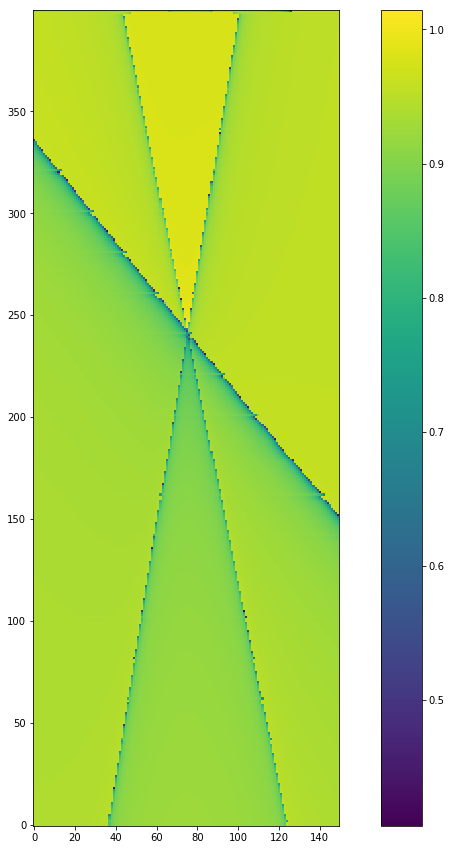

In [870]:
%matplotlib inline
#long
plt.figure(figsize=(15,15))
plt.imshow(allS[:,:,-1], origin = 'lower')
plt.colorbar()

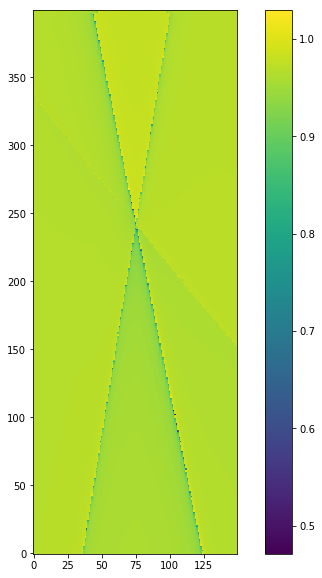

In [871]:
%matplotlib inline
#full
plt.figure(figsize=(10,10))
plt.imshow(allS[:,:,-2], origin = 'lower')
plt.colorbar()

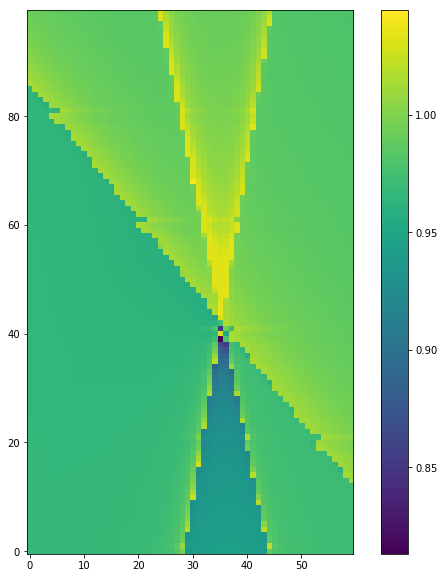

In [872]:
plt.figure(figsize=(10,10))
plt.imshow(allS[200:300,40:100,-3], origin = 'lower')
plt.colorbar()

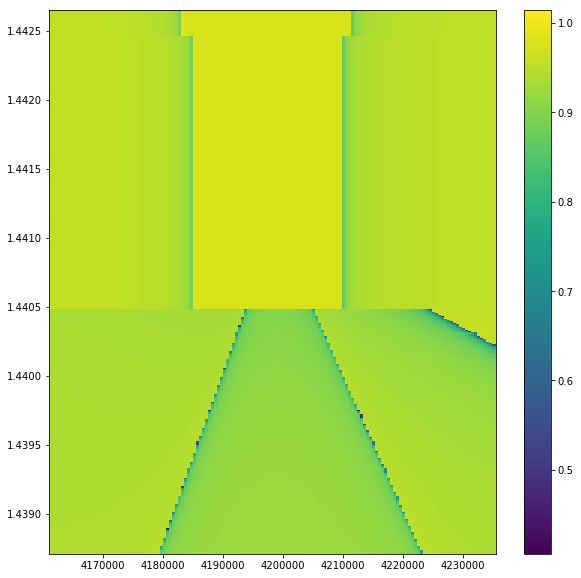

In [873]:
plt.figure(figsize=(10,10))
plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, allS[:,:,-1])
plt.colorbar()

In [887]:
from sympy.combinatorics import Permutation, PermutationGroup
Permutation.print_cyclic = True
import cmath
from cmath import exp, pi
from math import sqrt
import numpy as np
np.set_printoptions(linewidth=200)
import qpms
import numbers
ň = None

def grouprep_try(tdict, src, im, srcgens, imgens, immultop = None, imcmp = None):
    tdict[src] = im
    for i in range(len(srcgens)):
        new_src = src * srcgens[i]
        new_im = (im * imgens[i]) if (immultop is None) else immultop(im, imgens[i])
        if new_src not in tdict.keys():
            grouprep_try(tdict, new_src, new_im, srcgens, imgens, immultop, imcmp)
        elif ((new_im != tdict[new_src]) if (imcmp is None) else (not imcmp(new_im, tdict[new_src]))): # check consistency
            print(src, ' * ', srcgens[i], ' --> ', new_src)
            print(im)
            print(' * ')
            print(imgens[i])
            print(' --> ')
            print(new_im)
            print(' != ')
            print(tdict[new_src])
            raise ValueError("Homomorphism inconsistency detected")                
    return

# srcgroup is expected to be PermutationGroup and srcgens of the TODO
# imcmp returns True if two elements of the image group are 'equal', otherwise False
def generate_grouprep(srcgroup, im_identity, srcgens, imgens, immultop = None, imcmp = None):
    sz = srcgens[0].size
    for g in srcgens:
        if g.size != sz:
            raise ValueError('All the generators must have the same "size"')
    tdict = dict()
    grouprep_try(tdict, Permutation(sz-1), im_identity, srcgens, imgens, immultop = immultop, imcmp = imcmp)
    if(srcgroup.order() != len(tdict.keys())): # basic check
        raise ValueError('The supplied "generators" failed to generate the preimage group: ', 
                         srcgroup.order(), " != ", len(tdict.keys()))
    return tdict
    
epsilon = np.eye(2)
alif = np.array(((-1/2,-sqrt(3)/2),(sqrt(3)/2,-1/2)))
bih = np.array(((-1/2,sqrt(3)/2),(-sqrt(3)/2,-1/2)))
lam = np.array(((1,0),(0,-1)))
mim =  np.array(((-1/2,-sqrt(3)/2),(-sqrt(3)/2,1/2)))
nun =  np.array(((-1/2,sqrt(3)/2),(sqrt(3)/2,1/2)))


# Group D3h
# Note that the size argument of permutations is necessary, otherwise e.g. c*c and  b*b would not be evaluated equal
# N.B. the weird elements as Permutation(N) – it means identity permutation of size N+1.
rot3_perm = Permutation(0,1,2, size=5) # C3 rotation
xflip_perm = Permutation(0,2, size=5) # vertical mirror
zflip_perm = Permutation(3,4, size=5) # horizontal mirror
D3h_srcgens = [rot3_perm,xflip_perm,zflip_perm]
D3h_permgroup = PermutationGroup(rot3_perm,xflip_perm,zflip_perm) # D3h

#srcgens = [a,b,c]
D3h_irreps = {
    # Bradley, Cracknell p. 61
    'E1' : generate_grouprep(D3h_permgroup, epsilon, D3h_srcgens, [alif, lam, epsilon], immultop = np.dot, imcmp = np.allclose),
    'E2' : generate_grouprep(D3h_permgroup, epsilon, D3h_srcgens, [alif, lam, -epsilon], immultop = np.dot, imcmp = np.allclose),
    # Bradley, Cracknell p. 59,
    'A1p' : generate_grouprep(D3h_permgroup, 1, D3h_srcgens, [1,1,1]),
    'A2p' : generate_grouprep(D3h_permgroup, 1, D3h_srcgens, [1,-1,1]),
    'A1pp' : generate_grouprep(D3h_permgroup, 1, D3h_srcgens, [1,1,-1]),
    'A2pp' : generate_grouprep(D3h_permgroup, 1, D3h_srcgens, [1,-1,-1]),
}


def mmult_tyty(a, b):
        return(qpms.apply_ndmatrix_left(a, b, (-4,-3)))
def mmult_ptypty(a, b):
    return(qpms.apply_ndmatrix_left(a, b, (-6,-5,-4)))
    
#TODO lepší název fce
def gen_point_D3h_svwf_rep(lMax):
    my, ny = qpms.get_mn_y(lMax)
    nelem = len(my)
    C3_yy = qpms.WignerD_yy_fromvector(lMax, np.array([0,0,2*pi/3]))
    C3_tyty = np.moveaxis(np.eye(2)[:,:,ň,ň] * C3_yy, 2,1)
    zfl_tyty = qpms.zflip_tyty(lMax)
    yfl_tyty = qpms.yflip_tyty(lMax)
    xfl_tyty = qpms.xflip_tyty(lMax)
    I_tyty = np.moveaxis(np.eye(2)[:,:,ň,ň] * np.eye(nelem), 2,1)
    order = D3h_permgroup.order()
    sphrep_full = generate_grouprep(D3h_permgroup, I_tyty, D3h_srcgens, [C3_tyty, xfl_tyty, zfl_tyty], 
                           immultop = mmult_tyty, imcmp = np.allclose)
    sphreps = dict()
    for repkey, matrixrep in D3h_irreps.items():
        arepmatrix = matrixrep[rot3_perm] # just one of the matrices to get the shape etc
        if isinstance(arepmatrix, numbers.Number):
            dim = 1 # repre dimension
            preprocess = lambda x: np.array([[x]])
        elif isinstance(arepmatrix, np.ndarray):
            if(len(arepmatrix.shape)) != 2 or arepmatrix.shape[0] != arepmatrix.shape[1]:
                raise ValueError("Arrays representing irrep matrices must be of square shape")
            dim = arepmatrix.shape[0]
            preprocess = lambda x: x
        else: 
            raise ValueError("Irrep is not a square array or number")
        sphrep = np.zeros((dim,dim,2,nelem,2,nelem), dtype=complex)
        for i in D3h_permgroup.elements:
            sphrep += preprocess(matrixrep[i]).conj().transpose()[:,:,ň,ň,ň,ň] * sphrep_full[i]
        sphrep *= dim / order
        # clean the nonexact values here 
        for x in [0, 0.5, -0.5, 0.5j, -0.5j]:
            sphrep[np.isclose(sphrep,x)]=x
        sphreps[repkey] = sphrep
    return sphreps
        
def gen_hexlattice_Kpoint_svwf_rep(lMax, psi):
    my, ny = qpms.get_mn_y(lMax)
    nelem = len(my)
    C3_yy = qpms.WignerD_yy_fromvector(lMax, np.array([0,0,2*pi/3]))
    C3_tyty = np.moveaxis(np.eye(2)[:,:,ň,ň] * C3_yy, 2,1)
    zfl_tyty = qpms.zflip_tyty(lMax)
    yfl_tyty = qpms.yflip_tyty(lMax)
    xfl_tyty = qpms.xflip_tyty(lMax)
    I_tyty = np.moveaxis(np.eye(2)[:,:,ň,ň] * np.eye(nelem), 2,1)
    hex_C3_K_ptypty = np.diag([exp(-psi*1j*2*pi/3),exp(+psi*1j*2*pi/3)])[:,ň,ň,:,ň,ň] * C3_tyty[ň,:,:,ň,:,:]
    hex_zfl_ptypty = np.eye(2)[:,ň,ň,:,ň,ň] * zfl_tyty[ň,:,:,ň,:,:]
    hex_xfl_ptypty = np.array([[0,1],[1,0]])[:,ň,ň,:,ň,ň] * xfl_tyty[ň,:,:,ň,:,:]
    hex_I_ptypty = np.eye((2*2*nelem)).reshape((2,2,nelem,2,2,nelem))
    order = D3h_permgroup.order()
    hex_K_sphrep_full = generate_grouprep(D3h_permgroup, hex_I_ptypty, D3h_srcgens, [hex_C3_K_ptypty, hex_xfl_ptypty, hex_zfl_ptypty], 
                           immultop = mmult_ptypty, imcmp = np.allclose)
    hex_K_sphreps = dict()
    for repkey, matrixrep in D3h_irreps.items():
        arepmatrix = matrixrep[rot3_perm] # just one of the matrices to get the shape etc
        if isinstance(arepmatrix, numbers.Number):
            dim = 1 # repre dimension
            preprocess = lambda x: np.array([[x]])
        elif isinstance(arepmatrix, np.ndarray):
            if(len(arepmatrix.shape)) != 2 or arepmatrix.shape[0] != arepmatrix.shape[1]:
                raise ValueError("Arrays representing irrep matrices must be of square shape")
            dim = arepmatrix.shape[0]
            preprocess = lambda x: x
        else: 
            raise ValueError("Irrep is not a square array or number")
        sphrep = np.zeros((dim,dim,2,2,nelem,2,2,nelem), dtype=complex)
        for i in D3h_permgroup.elements:
            sphrep += preprocess(matrixrep[i]).conj().transpose()[:,:,ň,ň,ň,ň,ň,ň] * hex_K_sphrep_full[i]
        sphrep *= dim / order
        # clean the nonexact values here 
        for x in [0, 0.5, -0.5, 0.5j, -0.5j]:
            sphrep[np.isclose(sphrep,x)]=x
        hex_K_sphreps[repkey] = sphrep
    return hex_K_sphreps        

def normalize(v):
    norm = np.linalg.norm(v.reshape((np.prod(v.shape),)), ord=2)
    if norm == 0: 
       return v*np.nan
    return v / norm

def gen_hexlattice_Kpoint_svwf_rep_projectors(lMax,psi):
    nelem = lMax * (lMax+2)
    projectors = dict()
    for repi, W in gen_hexlattice_Kpoint_svwf_rep(lMax,psi).items():
        totalvecs = 0
        tmplist = list()
        for p in (0,1):
         for t in (0,1):
          for y in range(nelem):
           for ai in range(W.shape[0]):
            for bi in range(W.shape[1]):
                v = np.zeros((2,2,nelem))
                v[p,t,y] = 1
                #v = np.ones((2,2,nelem))
                v1 = np.tensordot(W[ai,bi],v, axes = ([-3,-2,-1],[0,1,2])) 


                if not np.allclose(v1,0):
                    v1 = normalize(v1)
                    for v2 in tmplist:
                        dot = np.tensordot(v1.conjugate(),v2,axes = ([-3,-2,-1],[0,1,2]))
                        if not np.allclose(dot,0):
                            if not np.allclose(np.abs(dot),1):
                                raise ValueError('You have to fix this piece of code.')# TODO maybe I should make sure that the absolute value is around 1
                            break
                    else:
                        totalvecs += 1
                        tmplist.append(v1)
                        #for index, x in np.ndenumerate(v1):
                        #    if x!=0:
                        #        print(index, x)
                        #print('----------')
        theprojector = np.zeros((2,2,nelem,2,2,nelem), dtype = float) 
        for v in tmplist:
            theprojector += (v[:,:,:,ň,ň,ň] * v.conjugate()[ň,ň,ň,:,:,:]).real # TODO check is it possible to have imaginary elements?
        for x in [0, 1, -1,sqrt(0.5),-sqrt(0.5),0.5,-0.5]:
            theprojector[np.isclose(theprojector,x)]=x
        projectors[repi] = theprojector
    return projectors

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


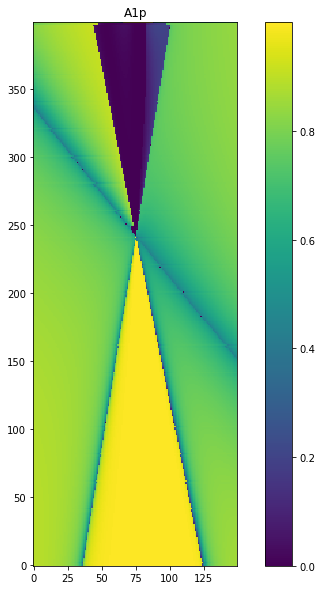

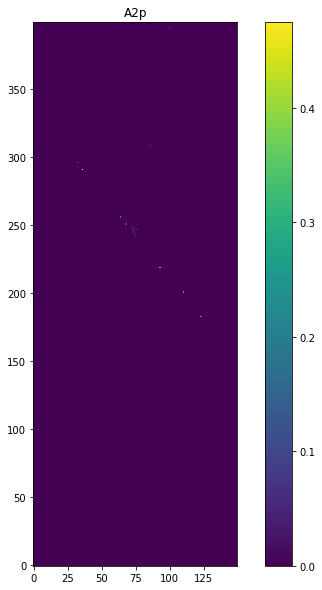

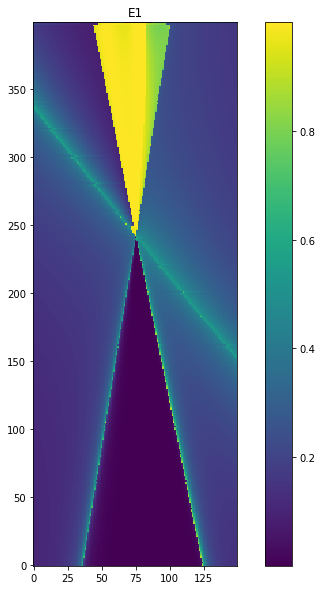

In [915]:
psi = -1
reps =  gen_hexlattice_Kpoint_svwf_rep(lMax, psi)
projmats = gen_hexlattice_Kpoint_svwf_rep_projectors(lMax,psi)
for sorder in (-1,):#,-2,-3,-4,-5):
    # Change this for full / zsym solutions
    #theV = allV[:,:,sorder,:].reshape(nomega,nk,2,2,nelem)
    theV = allV_expanded[:,:,sorder,:,:,:]

    theVprojections_v1 = dict() # non-normalised projector (probably this one is correct)
    theVprojections_v2 = dict() # normalised projector
    theVprojections_v3 = dict() # normalised projector squared

    for repkey, rep in reps.items():
        genvec = np.ones((2,2,nelem))
        symproj = np.tensordot(rep, genvec, axes = ([-3,-2,-1],[0,1,2])) #[d,d,p,t,y]; old method
        projmat = projmats[repkey]
        #FIXME tenhle přísstup je možná taky blbě, já vlastně chci spíš možná sčítat čtverce z theV...
        theVprojections_pre = np.abs(np.sum(theV[:,:,ň,ň,:,:,:] * symproj, axis=(-3,-2,-1))) #[nomega,nk,d,d] # raději kvadrát???
        theVprojections_v1[repkey] = np.sum(theVprojections_pre, axis = (-2,-1))
        theVprojections_v2[repkey] = np.sum(theVprojections_pre / np.sum(symproj*symproj.conj(),axis=(-3,-2,-1)).real,(-2,-1))
        theV_halfproj = np.tensordot(theV.conjugate(),projmat, axes=([-3,-2,-1],[0,1,2])) 
        theVprojections_v3[repkey] = np.sum( theV_halfproj[:,:,:,:,:] * theV[:,:,:], axis = (-3,-2,-1)  ).real
        
        
                                                  

    if TE_or_TM is None:
        repkeylist = ['A1p', 'A1pp', 'A2p', 'A2pp', 'E1', 'E2']# list(reps.keys())
    elif TE_or_TM ==0:
        repkeylist = ['A1p', 'A2p', 'E1',]# list(reps.keys())
    elif TE_or_TM ==1:
        repkeylist = ['A1pp', 'A2pp', 'E2']# list(reps.keys())
    else:
        raise ValueError('TE_or_TM has wrong value (or has not been set?)')


    theVprojections_v1_arr = np.empty((nomega,nk,len(repkeylist)), dtype=float)
    theVprojections_v2_arr = np.empty((nomega,nk,len(repkeylist)), dtype=float)
    theVprojections_v3_arr = np.empty((nomega,nk,len(repkeylist)), dtype=float)
    for i in range(len(repkeylist)):
        theVprojections_v1_arr[:,:,i] = theVprojections_v1[repkeylist[i]]
        theVprojections_v2_arr[:,:,i] = theVprojections_v2[repkeylist[i]]
        theVprojections_v3_arr[:,:,i] = theVprojections_v3[repkeylist[i]]

    for key in repkeylist:
        plt.figure(figsize=(10,10))
        plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, theVprojections_v3[key], )
        plt.title(key)
        plt.colorbar()
        plt.imshow(theVprojections_v3[key], origin = 'lower')

In [916]:
theVprojections_v1_order = np.argsort(theVprojections_v1_arr, axis = -1)
theVprojections_v2_order = np.argsort(theVprojections_v2_arr, axis = -1)
theVprojections_v3_order = np.argsort(theVprojections_v3_arr, axis = -1)

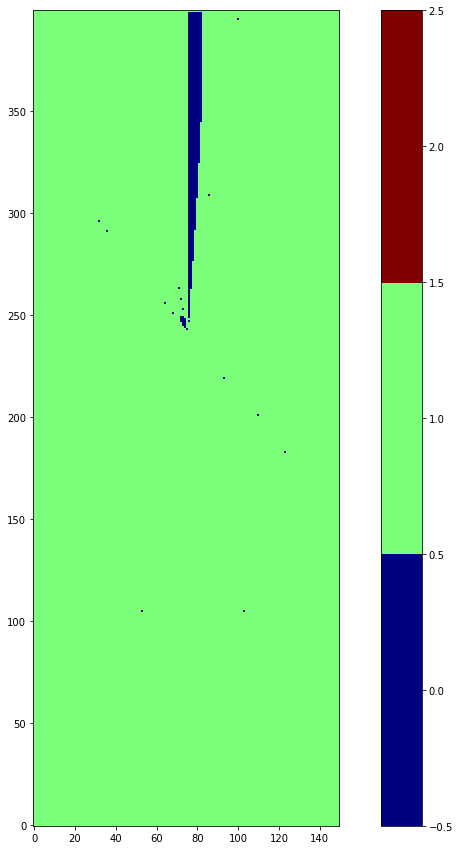

In [917]:
cmap = plt.get_cmap('jet', len(repkeylist))

plt.figure(figsize=(15,15))
plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, theVprojections_v1_order[:,:,0], cmap=cmap, vmin = -0.5, vmax = len(repkeylist)-0.5)
plt.colorbar()

plt.imshow(theVprojections_v3_order[:,:,0], cmap=cmap, vmin = -0.5, vmax = len(repkeylist)-0.5, origin='lower')

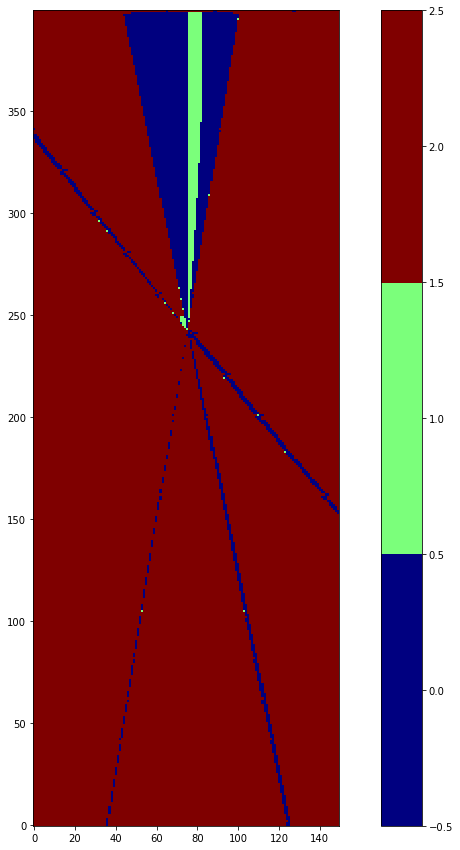

In [918]:
cmap = plt.get_cmap('jet', len(repkeylist))

plt.figure(figsize=(15,15))
plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, theVprojections_v3_order[:,:,0], cmap=cmap, vmin = -0.5, vmax = len(repkeylist)-0.5)
plt.colorbar()

plt.imshow(theVprojections_v3_order[:,:,1], cmap=cmap, vmin = -0.5, vmax = len(repkeylist)-0.5, origin='lower')

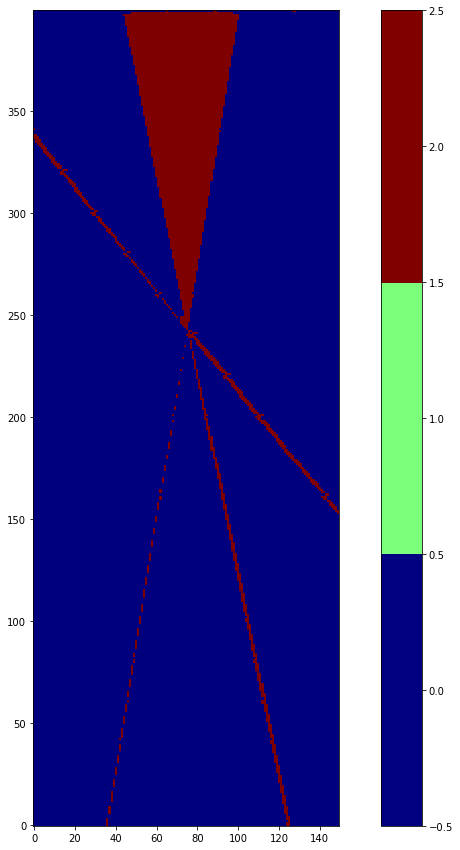

In [919]:
cmap = plt.get_cmap('jet', len(repkeylist))

plt.figure(figsize=(15,15))
plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, theVprojections_v1_order[:,:,0], cmap=cmap, vmin = -0.5, vmax = len(repkeylist)-0.5)
plt.colorbar()

plt.imshow(theVprojections_v3_order[:,:,-1], cmap=cmap, vmin = -0.5, vmax = len(repkeylist)-0.5, origin='lower')

In [920]:
theVprojections_v3_order.shape

(400, 150, 3)

In [921]:
np.amax(theVprojections_v3_arr[:,:,1])

0.47458412261844785

In [922]:
theVprojections_v3_order[0,74,0]

1

In [923]:
theVprojections_v3_arr[0,0,1]

8.874685183736383e-31

In [924]:
np.amax(theVprojections_v3['A1p'][:,75])

0.9999998555217754

In [925]:
np.amax(theVprojections_v3['E1'][:,75])

0.9999722571260119

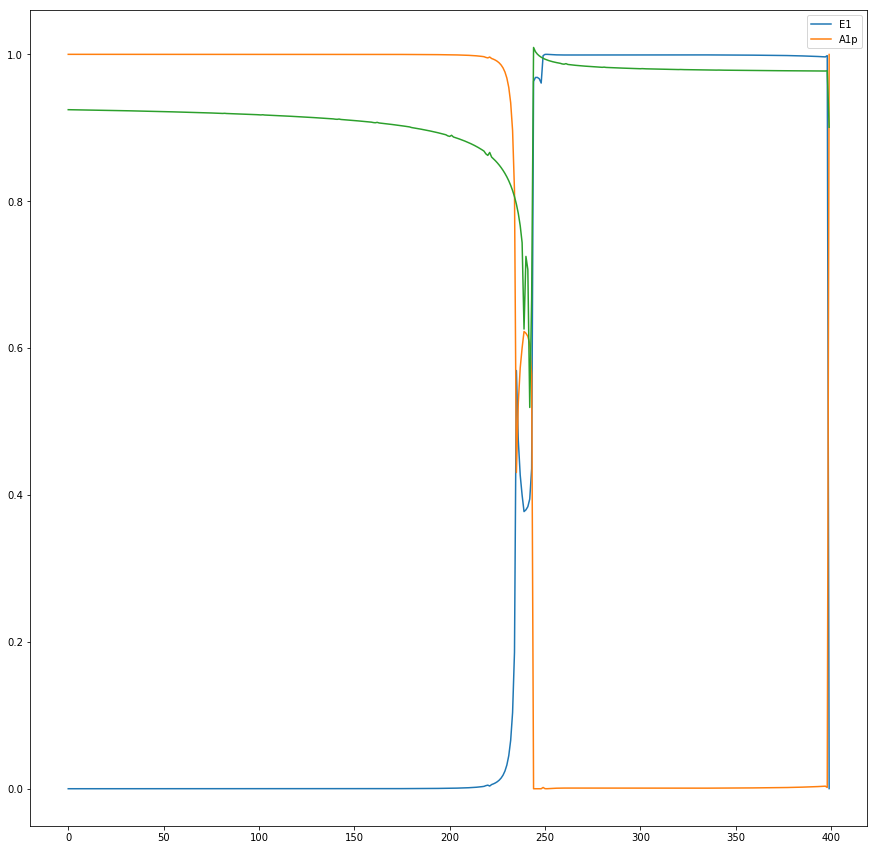

In [926]:

plt.figure(figsize=(15,15))
plt.plot(theVprojections_v3['E1'][:,74],label = 'E1')
plt.plot(theVprojections_v3['A1p'][:,74], label= 'A1p')
plt.plot(allS[:,75,-1])
plt.legend()

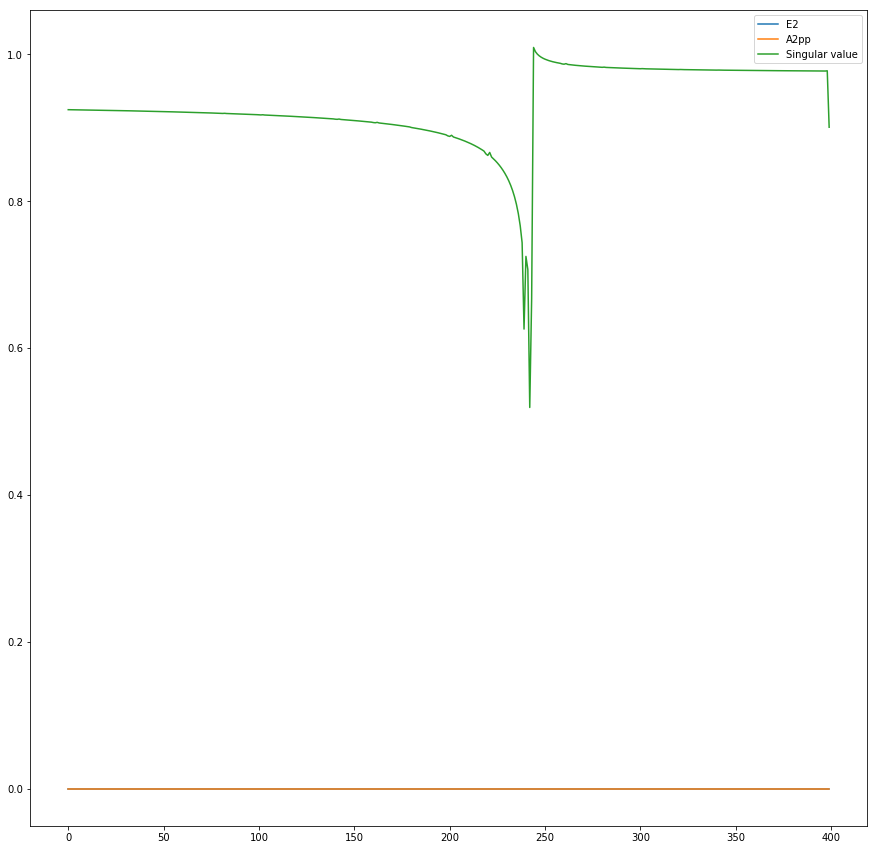

In [914]:

plt.figure(figsize=(15,15))
plt.plot(theVprojections_v3['E2'][:,75], label='E2')
plt.plot(theVprojections_v3['A2pp'][:,75], label='A2pp')
plt.plot(allS[:,75,-1], label='Singular value')
plt.legend()

In [857]:
Wmatrices.shape

(400, 150, 2, 2, 3, 2, 2, 3)

In [858]:
Wmatrices[200,75,1,0,0,0,0,0]

(-4.536411198979544e-06+0.0004961656606349012j)